# Handwritten Character Recognition Machine learning & Deep Learning

Create a handwritten character recognition system that can recognize various handwritten characters or alphabets. You can extend this to recognize entire words or sentences.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/handwritten-character-to-classifier/handwritten_characters.csv
/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv
/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data/A_Z Handwritten Data.csv


#  Import necessary libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import SGD
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import random

# Load the  dataset

In [3]:
alphabet_data = pd.read_csv('/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv').astype('float32')
mnist_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
mnist_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Explore the dataset

Display the first few rows of the DataFrame

In [4]:
alphabet_data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
alphabet_data.shape

(372450, 785)

In [6]:
labels, counts = np.unique(alphabet_data['0'], return_counts = True)
for l, c in zip(labels, counts):
    print("%s : %s" %(l,c))

0.0 : 13869
1.0 : 8668
2.0 : 23409
3.0 : 10134
4.0 : 11440
5.0 : 1163
6.0 : 5762
7.0 : 7218
8.0 : 1120
9.0 : 8493
10.0 : 5603
11.0 : 11586
12.0 : 12336
13.0 : 19010
14.0 : 57825
15.0 : 19341
16.0 : 5812
17.0 : 11566
18.0 : 48419
19.0 : 22495
20.0 : 29008
21.0 : 4182
22.0 : 10784
23.0 : 6272
24.0 : 10859
25.0 : 6076


([<matplotlib.patches.Wedge at 0x7f037cd6d2d0>,
 [Text(1.092481669600601, 0.12838925806578722, '0.0'),
  Text(1.0485415280079953, 0.33250663759188126, '1.0'),
  Text(0.9215231004494209, 0.6006622806020756, '2.0'),
  Text(0.7171950978201849, 0.8340450777162441, '3.0'),
  Text(0.5544135063470107, 0.9500661366347153, '4.0'),
  Text(0.4504766193246402, 1.0035291801646045, '5.0'),
  Text(0.391123571935982, 1.0281159231701642, '6.0'),
  Text(0.27644266646474874, 1.0646968827595298, '7.0'),
  Text(0.20094028786297546, 1.081491100616896, '8.0'),
  Text(0.11268337251233194, 1.0942131682443084, '9.0'),
  Text(-0.01790659482709213, 1.099854242098333, '10.0'),
  Text(-0.1766264293000523, 1.0857269935267861, '11.0'),
  Text(-0.39063791439969936, 1.0283005493694213, '12.0'),
  Text(-0.645790386454604, 0.890480082181973, '13.0'),
  Text(-1.0524029670365878, 0.3200749833595046, '14.0'),
  Text(-1.0311653530411335, -0.38301176834081063, '15.0'),
  Text(-0.9273910365281383, -0.5915622244255169, '16.0'),

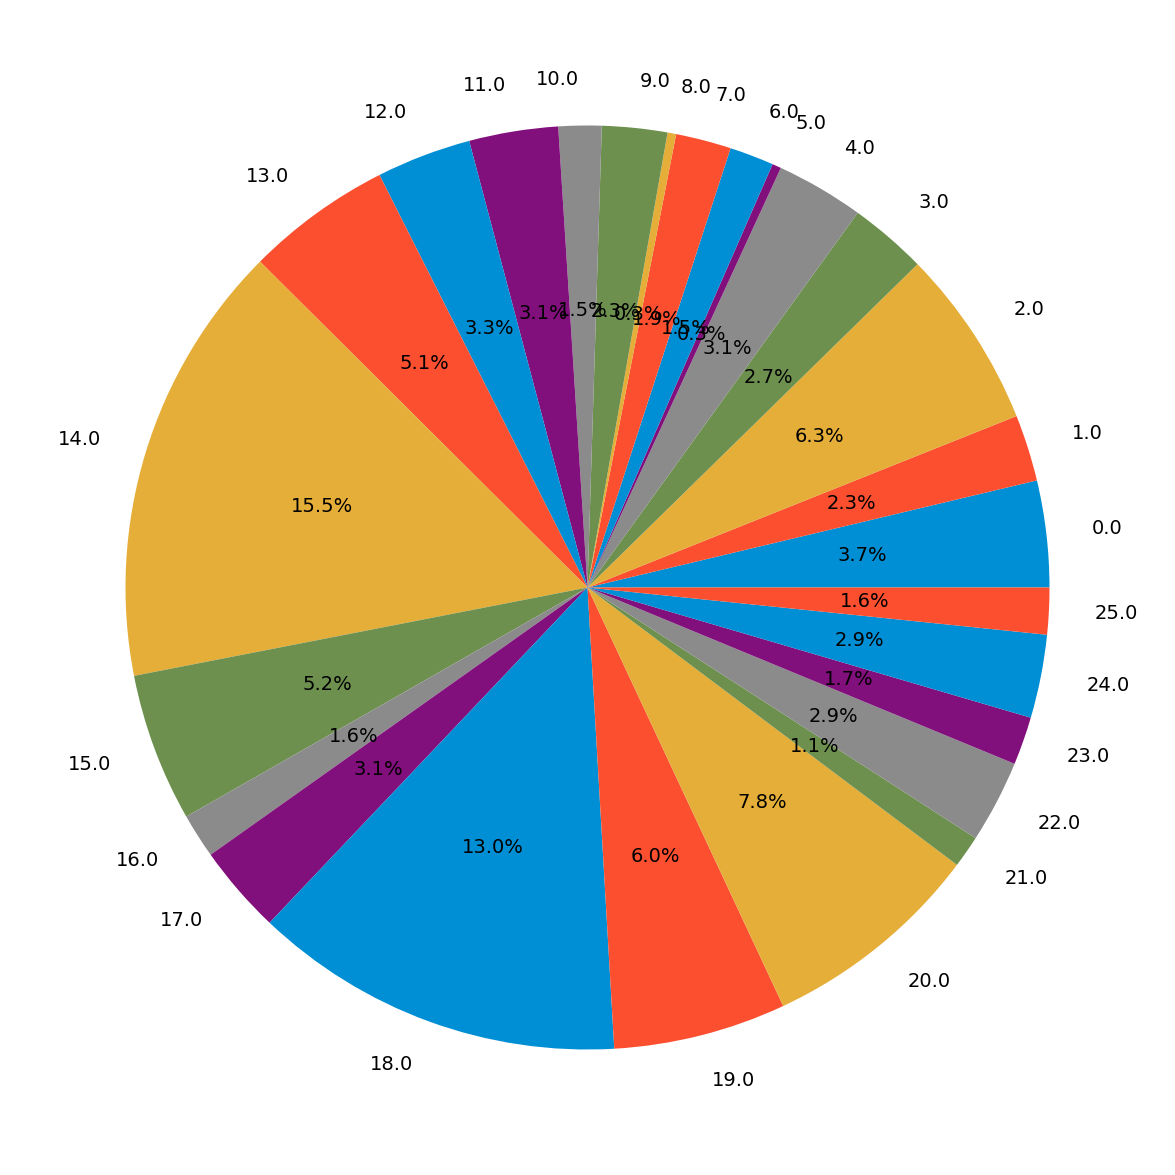

In [7]:
fig = plt.figure(figsize=(15, 15))
plt.style.use('fivethirtyeight')
plt.pie(counts, labels=labels, autopct='%1.1f%%')

In [8]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
mnist_train.shape

(42000, 785)

In [10]:
labels, counts = np.unique(mnist_train['label'], return_counts = True)
for l, c in zip(labels, counts):
    print("%s : %s" %(l,c))

0 : 4132
1 : 4684
2 : 4177
3 : 4351
4 : 4072
5 : 3795
6 : 4137
7 : 4401
8 : 4063
9 : 4188


([<matplotlib.patches.Wedge at 0x7f037ce03490>,
 [Text(1.0478775853613054, 0.33459313516173705, '0'),
  Text(0.6231824746370928, 0.9064455876141654, '1'),
  Text(-0.06652374479552087, 1.0979866080141327, '2'),
  Text(-0.7072974501061973, 0.8424549347432606, '3'),
  Text(-1.06785397686213, 0.26398462852926463, '4'),
  Text(-1.0347736198108923, -0.37315352838136584, '5'),
  Text(-0.6492899774485793, -0.88793159938411, '6'),
  Text(0.007980993080278602, -1.0999710467778017, '7'),
  Text(0.6572336414600355, -0.8820679908789241, '8'),
  Text(1.0464668240449817, -0.33897962501190143, '9')],
 [Text(0.5715695920152574, 0.18250534645185654, '9.8%'),
  Text(0.3399177134384142, 0.49442486597136287, '11.2%'),
  Text(-0.03628567897937501, 0.5989017861895268, '9.9%'),
  Text(-0.38579860914883485, 0.4595208734963239, '10.4%'),
  Text(-0.5824658055611617, 0.14399161556141704, '9.7%'),
  Text(-0.5644219744423049, -0.2035382882080177, '9.0%'),
  Text(-0.35415816951740686, -0.48432632693678723, '9.8%'),


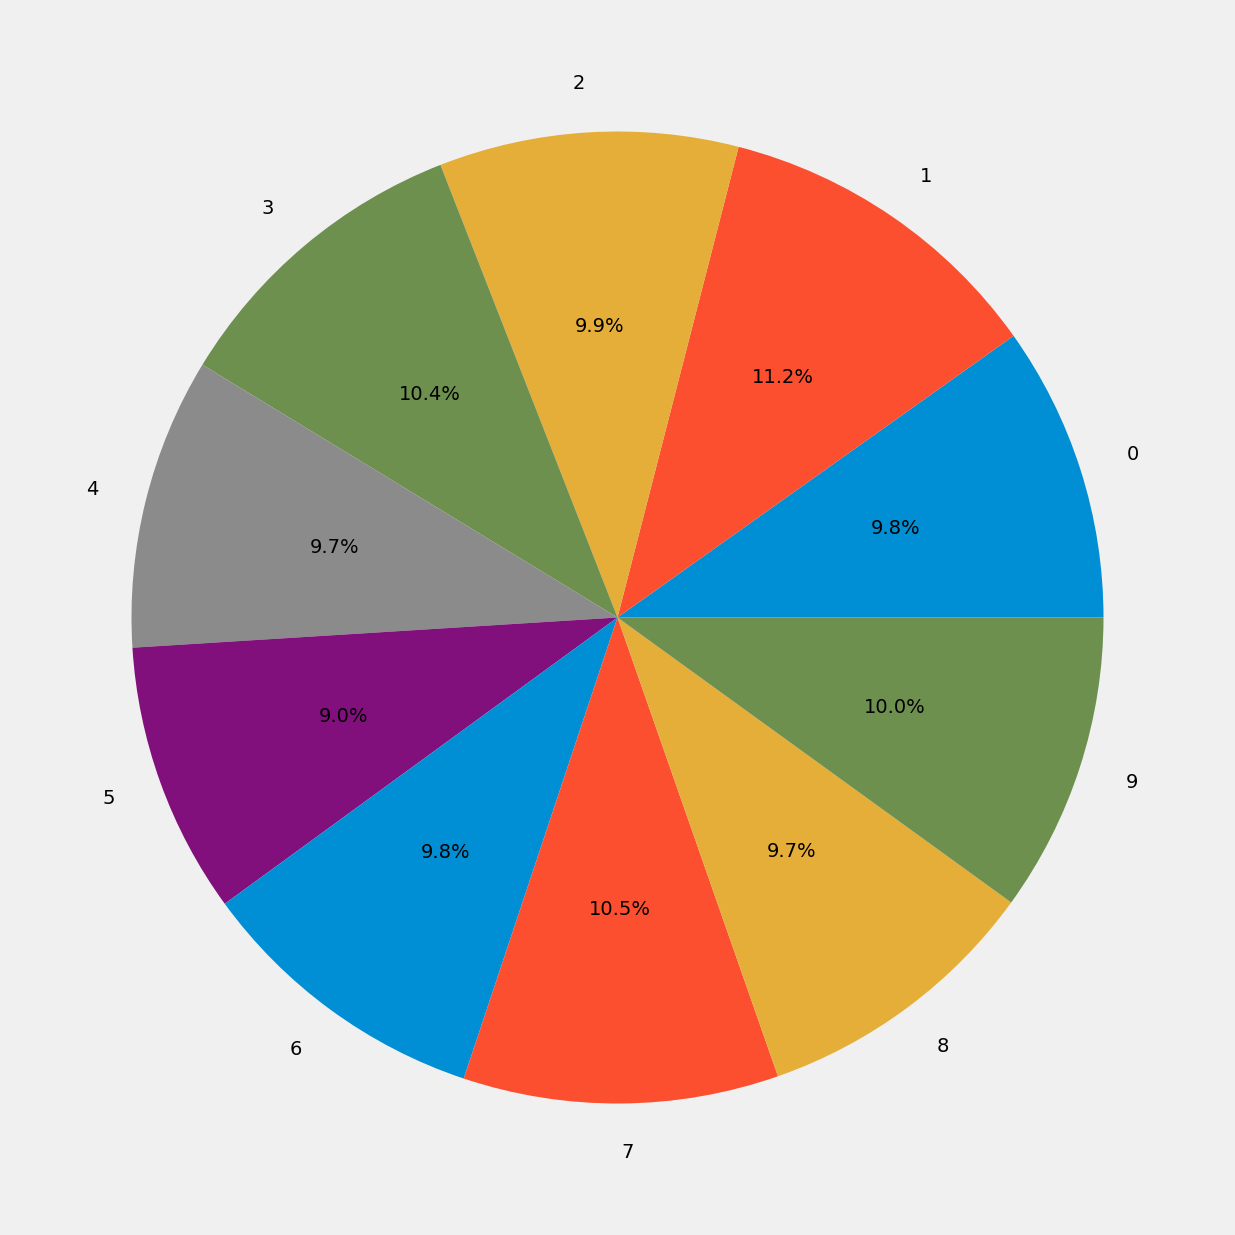

In [11]:
fig = plt.figure(figsize=(15, 15))
plt.style.use('fivethirtyeight')
plt.pie(counts, labels=labels, autopct='%1.1f%%')

In [ ]:
mnist_train['label'] = mnist_train['label'] + 26
labels, counts = np.unique(mnist_train['label'], return_counts = True)
for l, c in zip(labels, counts):
    print("%s : %s" %(l,c))

In [13]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Display descriptive statistics of numerical columns

In [14]:
alphabet_data.columns = mnist_train.columns

In [15]:
merge_data = pd.concat([alphabet_data, mnist_train], axis = 0)
merge_data.shape

(414450, 785)

In [16]:
labels, counts = np.unique(merge_data['label'], return_counts = True)
for l, c in zip(labels, counts):
    print("%s : %s" %(l,c))

0.0 : 13869
1.0 : 8668
2.0 : 23409
3.0 : 10134
4.0 : 11440
5.0 : 1163
6.0 : 5762
7.0 : 7218
8.0 : 1120
9.0 : 8493
10.0 : 5603
11.0 : 11586
12.0 : 12336
13.0 : 19010
14.0 : 57825
15.0 : 19341
16.0 : 5812
17.0 : 11566
18.0 : 48419
19.0 : 22495
20.0 : 29008
21.0 : 4182
22.0 : 10784
23.0 : 6272
24.0 : 10859
25.0 : 6076
26.0 : 4132
27.0 : 4684
28.0 : 4177
29.0 : 4351
30.0 : 4072
31.0 : 3795
32.0 : 4137
33.0 : 4401
34.0 : 4063
35.0 : 4188


# Making a list of letters with their positions

In [17]:
# All the labels are present in the form of floating point values, that we convert to integer values, 
# & so we create a dictionary word_dict to map the integer values with the characters.

word_dict = {
    0:'A',1:'B',2:'C',3:'D',
    4:'E',5:'F',6:'G',7:'H',
    8:'I',9:'J',10:'K',11:'L',
    12:'M',13:'N',14:'O',15:'P',
    16:'Q',17:'R',18:'S',19:'T',
    20:'U',21:'V',22:'W',23:'X',
    24:'Y',25:'Z',
    26:'0',27:'1',28:'2',29:'3',30:'4',
    31:'5',32:'6',33:'7',34:'8',35:'9'
}

In [18]:
merge_data_backup = merge_data

# Plot the number of letters in the dataset.

/tmp/ipykernel_34/579739017.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  y_integer = np.int0(merge_data['label'])


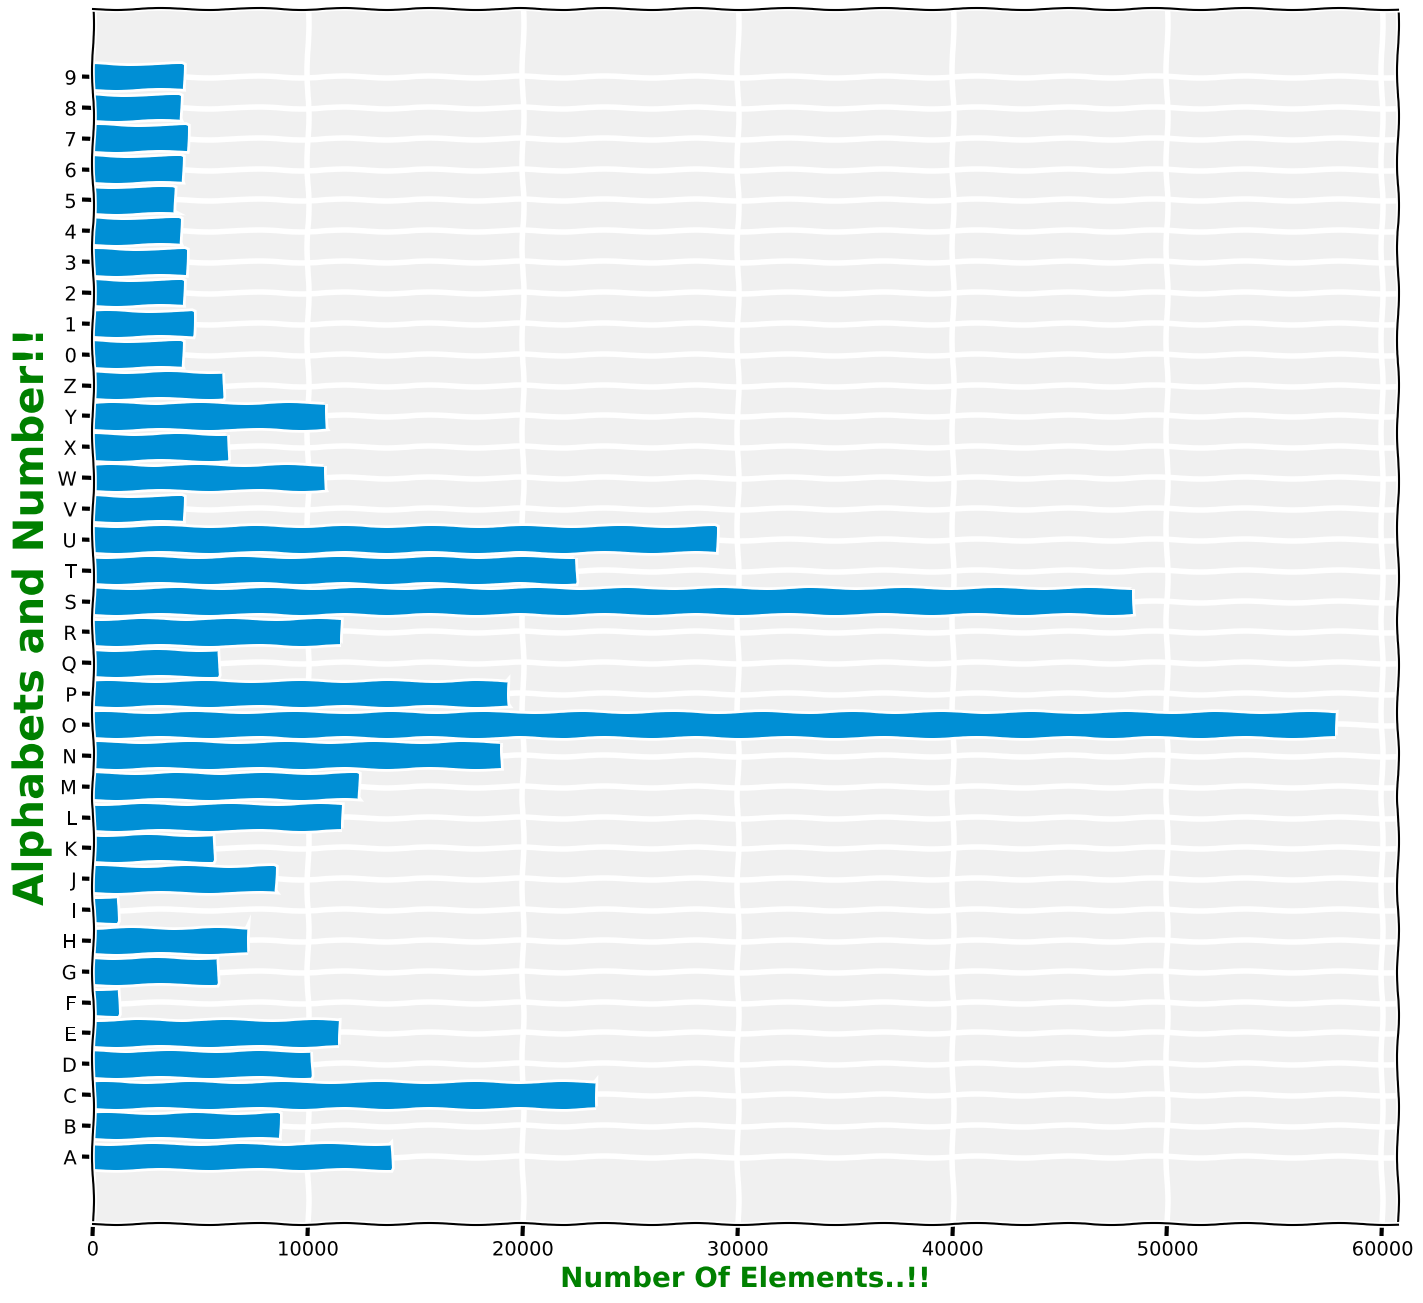

In [19]:
# Plotting the number of alphabets in the dataset
# 1): Firstly we convert the labels into integer values and append into the count list according to the label. 
#     This count list has the number of images present in the dataset belonging to each alphabet.
# 2): Now we create a list – alphabets containing all the characters using the values() function of the dictionary.
# 3): Now using the count & alphabets lists we draw the horizontal bar plot.

plt.style.use('fivethirtyeight')
plt.xkcd()

y_integer = np.int0(merge_data['label'])
count = np.zeros(36, dtype = 'int')

for i in y_integer:
    count[i] += 1
    
characters = []

for i in word_dict.values():
    characters.append(i)
    
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.barh(characters, count)

plt.xlabel('Number Of Elements..!!', fontsize = 20, fontweight = 'bold', color = 'green')
plt.ylabel('Alphabets and Number!!', fontsize = 30, fontweight = 'bold', color = 'green')
plt.grid()
plt.show()

# Generate images to make balanced data

In [20]:
def generateImageLabel(df, num_images_to_generate):
#     print(df)
    labels = df['label'].values
    
    images = df.drop('label', axis=1).values
    images = images.reshape(-1, 28, 28, 1)
    
    datagen = ImageDataGenerator(zoom_range = [0.6, 1])
    generated_images = []
    generated_labels = []
    generated_counts = 0 # Track the number of generated images

    
    for X_batch, y_batch in datagen.flow(images, labels, batch_size = num_images_to_generate):
        if generated_counts >= num_images_to_generate:
            break
        generated_images.append(X_batch)
        generated_labels.append(y_batch)
        generated_counts += X_batch.shape[0]

    # Truncate excess images and labels beyond the desired number     
    generated_images = np.concatenate(generated_images)
    generated_labels = np.concatenate(generated_labels)
    
    generated_images = generated_images.reshape(-1, 784)
    
    generated_df = pd.DataFrame(generated_images, columns = df.columns[1: ])
    generated_df['label'] = generated_labels
    
    #Get samples if the number of generated images is larger than num_images_to_generate
    if(generated_df.shape[0] > num_images_to_generate):
        print(generated_df.shape, num_images_to_generate)
        generated_df = generated_df.sample(num_images_to_generate)
    
    return generated_df

# Make balanced data 

In [21]:
# Create an empty DataFrame to store balanced data
balanced_df = pd.DataFrame(columns=mnist_train.columns)

In [22]:
target_count = 4000

# Iterate over each label
for label in range(0, 36):
    print(label)
    #temp_data to calculate
    temp_data = merge_data[merge_data['label'] == label]
    print('original shape: ', temp_data.shape)
    # Sample rows for the current label to achieve the target count
    if(temp_data.shape[0] > target_count):
        sampled_rows = temp_data.sample(n=target_count)
    elif(temp_data.shape[0] == target_count):
        sampled_rows = temp_data
    else:
        num_images_to_generate = target_count - temp_data.shape[0]
        sampled_rows = generateImageLabel(temp_data, num_images_to_generate)
        sampled_rows = pd.concat([temp_data, sampled_rows])
    print('sampled_rows: ', sampled_rows.shape)
    
    balanced_df = pd.concat([balanced_df, sampled_rows])



0
original shape:  (13869, 785)
sampled_rows:  (4000, 785)
1
original shape:  (8668, 785)
sampled_rows:  (4000, 785)
2
original shape:  (23409, 785)
sampled_rows:  (4000, 785)
3
original shape:  (10134, 785)
sampled_rows:  (4000, 785)
4


/tmp/ipykernel_34/2460417270.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_df = pd.concat([balanced_df, sampled_rows])


original shape:  (11440, 785)
sampled_rows:  (4000, 785)
5
original shape:  (1163, 785)
(3489, 785) 2837
sampled_rows:  (4000, 785)
6
original shape:  (5762, 785)
sampled_rows:  (4000, 785)
7
original shape:  (7218, 785)
sampled_rows:  (4000, 785)
8
original shape:  (1120, 785)
(3360, 785) 2880
sampled_rows:  (4000, 785)
9
original shape:  (8493, 785)
sampled_rows:  (4000, 785)
10
original shape:  (5603, 785)
sampled_rows:  (4000, 785)
11
original shape:  (11586, 785)
sampled_rows:  (4000, 785)
12
original shape:  (12336, 785)
sampled_rows:  (4000, 785)
13
original shape:  (19010, 785)
sampled_rows:  (4000, 785)
14
original shape:  (57825, 785)
sampled_rows:  (4000, 785)
15
original shape:  (19341, 785)
sampled_rows:  (4000, 785)
16
original shape:  (5812, 785)
sampled_rows:  (4000, 785)
17
original shape:  (11566, 785)
sampled_rows:  (4000, 785)
18
original shape:  (48419, 785)
sampled_rows:  (4000, 785)
19
original shape:  (22495, 785)
sampled_rows:  (4000, 785)
20
original shape:  (

In [23]:
balanced_df['label'].value_counts()

label
0.0     4000
1.0     4000
2.0     4000
3.0     4000
4.0     4000
5.0     4000
6.0     4000
7.0     4000
8.0     4000
9.0     4000
10.0    4000
11.0    4000
12.0    4000
13.0    4000
14.0    4000
15.0    4000
16.0    4000
17.0    4000
18.0    4000
19.0    4000
20.0    4000
21.0    4000
22.0    4000
23.0    4000
24.0    4000
25.0    4000
26.0    4000
27.0    4000
28.0    4000
29.0    4000
30.0    4000
31.0    4000
32.0    4000
33.0    4000
34.0    4000
35.0    4000
Name: count, dtype: int64

/tmp/ipykernel_34/2304146961.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  y_integer = np.int0(balanced_df['label'])


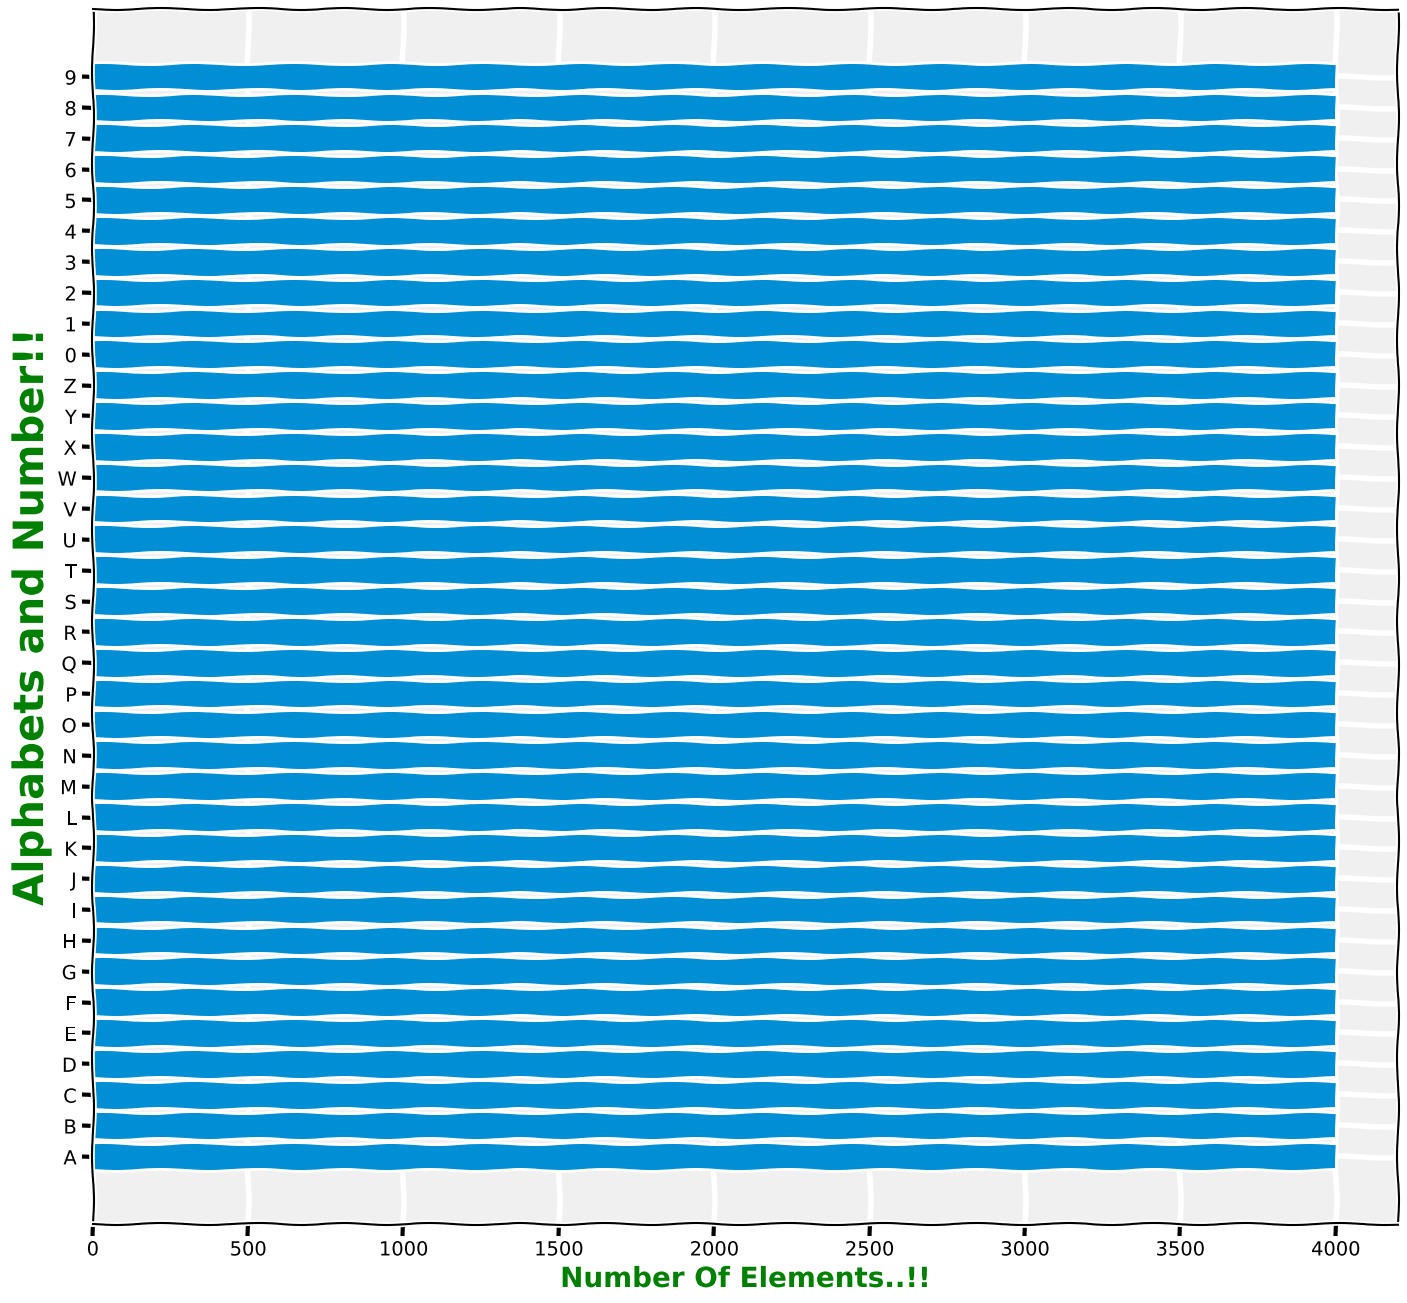

In [24]:
# Plotting the number of alphabets in the dataset
# 1): Firstly we convert the labels into integer values and append into the count list according to the label. 
#     This count list has the number of images present in the dataset belonging to each alphabet.
# 2): Now we create a list – alphabets containing all the characters using the values() function of the dictionary.
# 3): Now using the count & alphabets lists we draw the horizontal bar plot.

# plt.style.use('fivethirtyeight')
plt.xkcd()

y_integer = np.int0(balanced_df['label'])
count = np.zeros(36, dtype = 'int')

for i in y_integer:
    count[i] += 1
    
characters = []

for i in word_dict.values():
    characters.append(i)
    
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.barh(characters, count)

plt.xlabel('Number Of Elements..!!', fontsize = 20, fontweight = 'bold', color = 'green')
plt.ylabel('Alphabets and Number!!', fontsize = 30, fontweight = 'bold', color = 'green')
plt.grid()
plt.show()

In [25]:
# Shuffle the rows to ensure randomness
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [26]:
# balanced_df.to_csv('/kaggle/working/handwritten_characters.csv')

# Defind my_data to apply to model

In [27]:
my_df = balanced_df
my_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
my_df.shape

(144000, 785)

In [29]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144000 entries, 0 to 143999
Columns: 785 entries, label to pixel783
dtypes: float64(785)
memory usage: 862.4 MB


In [30]:
my_df.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

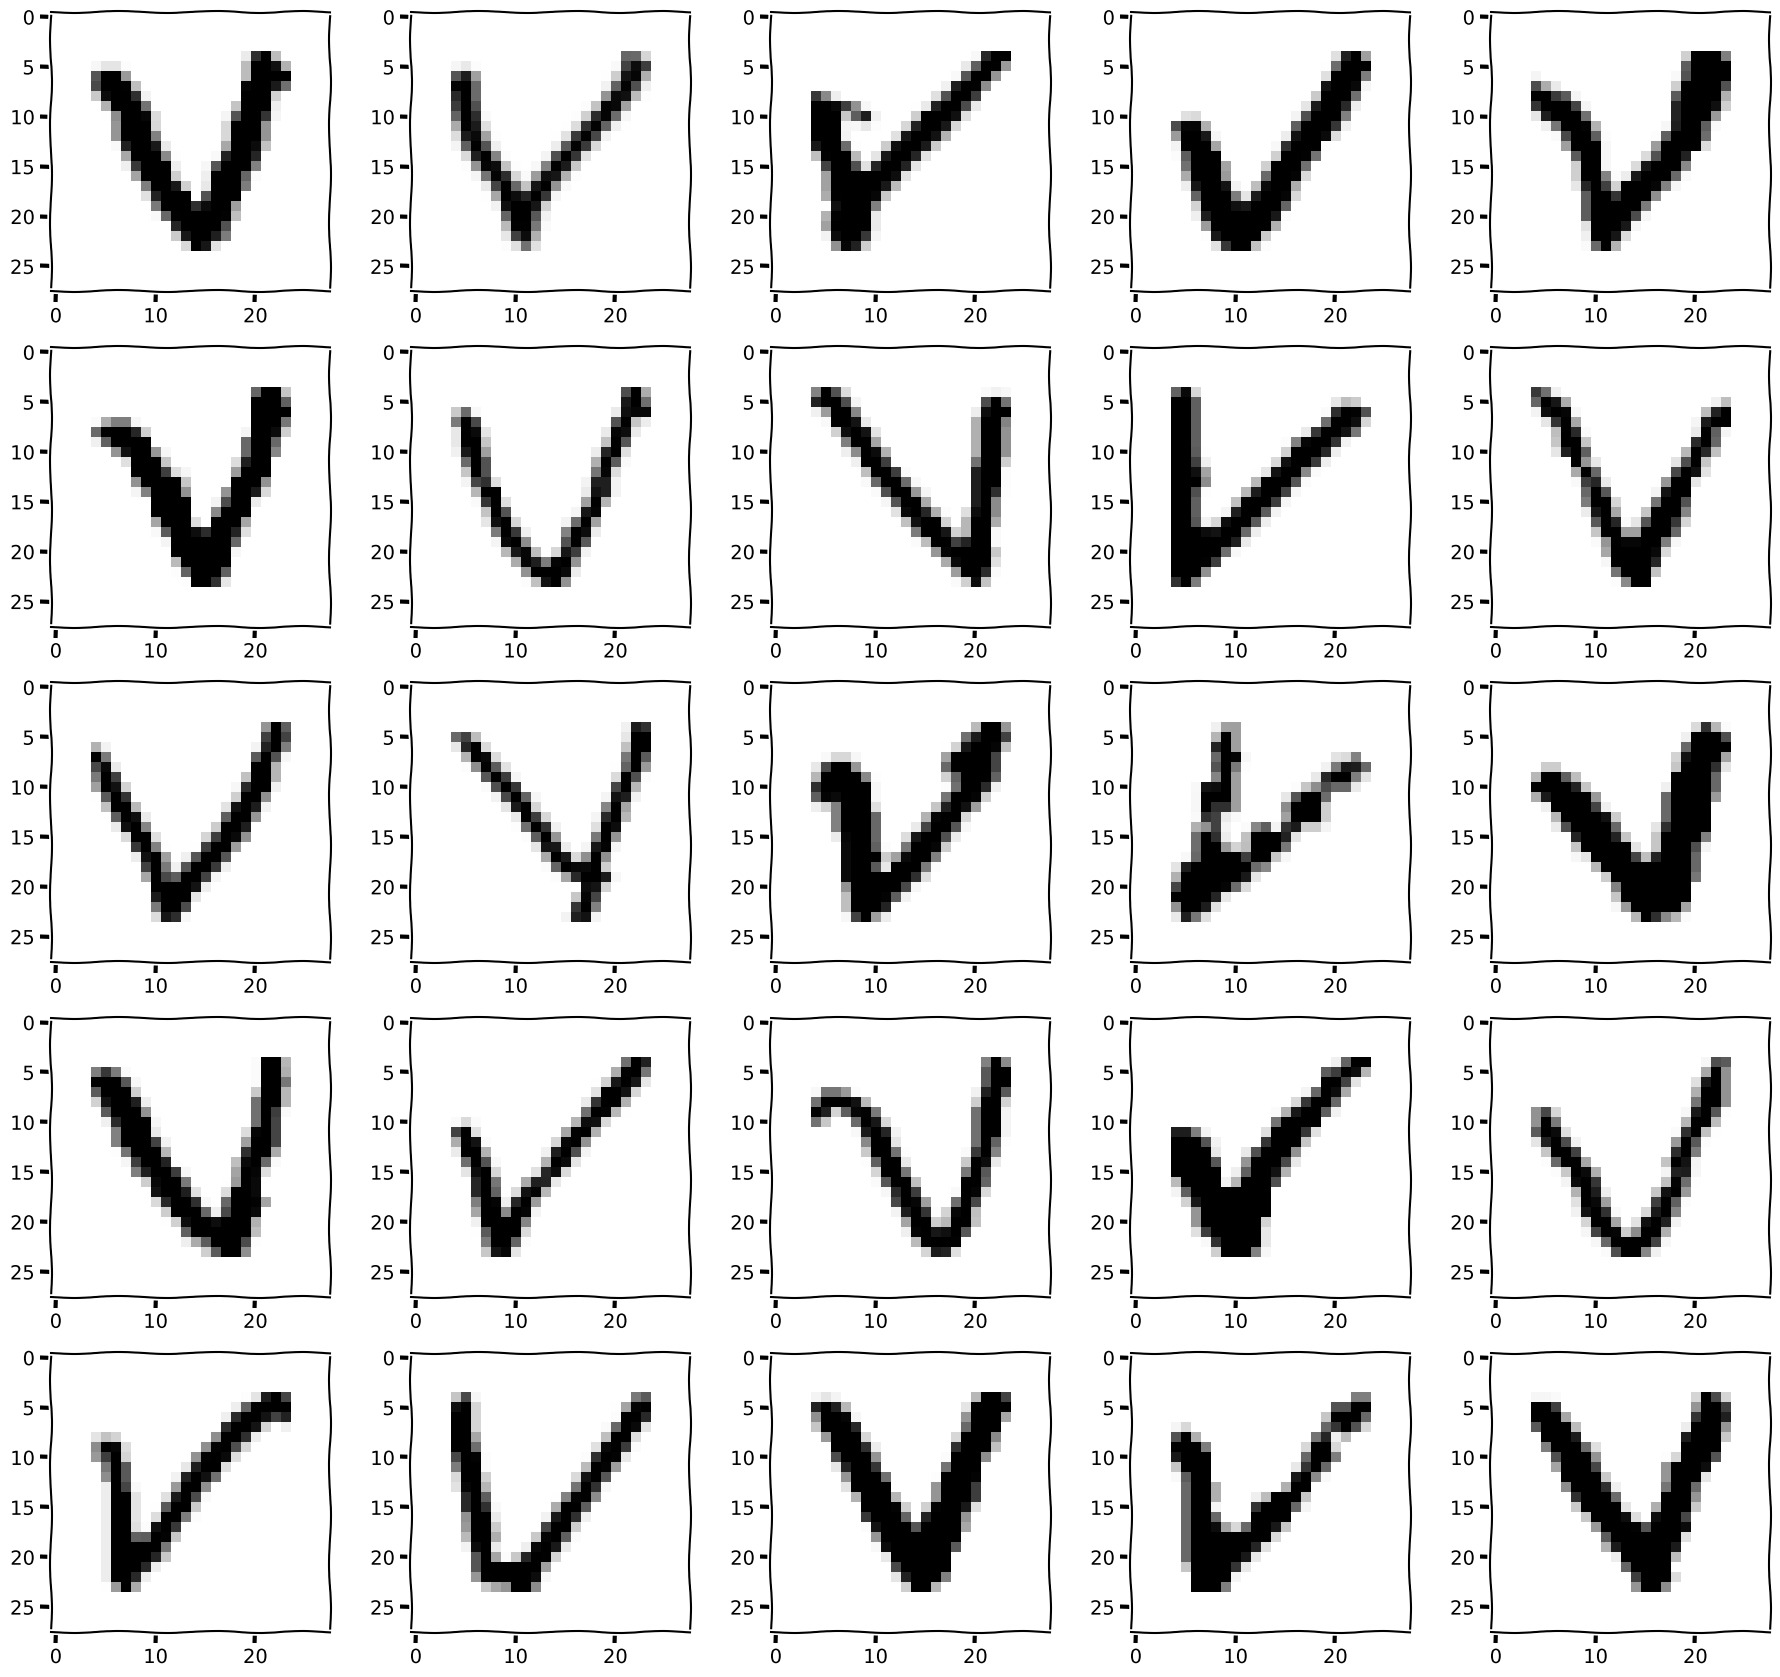

In [31]:
label_tmp = my_df[my_df['label']==21]
images_tmp = label_tmp.drop(columns=['label'],axis=1)
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
axs = axs.flatten()
for i, ax in enumerate(axs):
    index = random.randint(0, images_tmp.shape[0])
#     _, shu = cv2.threshold(images_a.iloc[index], 30, 200, cv2.THRESH_BINARY)
    ax.imshow(np.reshape(images_tmp.iloc[index], (28, 28)), cmap='Greys')
plt.show()

# Separate the columns for x and y in the dataset.

In [32]:
x = my_df.drop('label', axis = 1)
y = my_df['label']

# Changing the shape of images in a dataset

In [33]:
# we are reshaping the train & test image data so that they can be displayed as an image, 
# as initially in the CSV file they were present as 784 columns of pixel data. So we convert it to 28×28 pixels.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
x_train = np.reshape(x_train.values, (x_train.shape[0], 28, 28))
x_test = np.reshape(x_test.values, (x_test.shape[0], 28, 28))

print('Train Data Shape:', x_train.shape)
print('Test Data Shape:', x_test.shape)

Train Data Shape: (115200, 28, 28)
Test Data Shape: (28800, 28, 28)


# Plot the number of letters in the dataset.

/tmp/ipykernel_34/795725345.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  y_integer = np.int0(y)


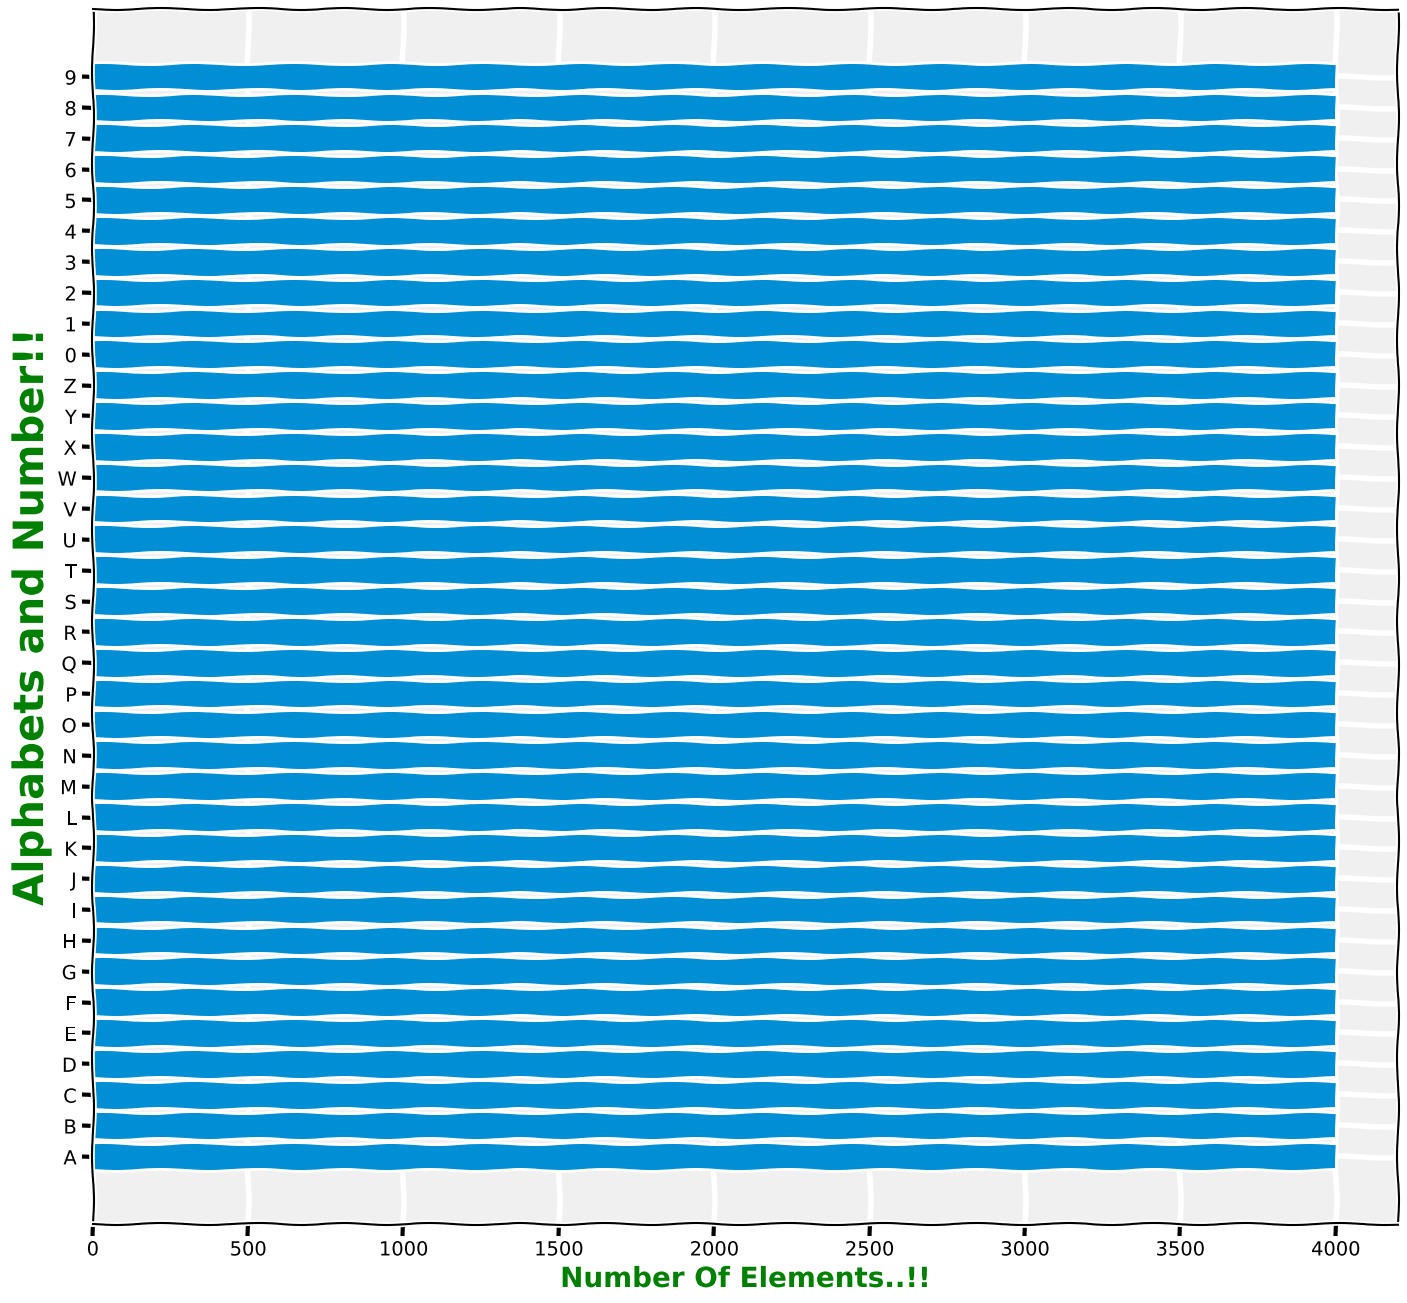

In [34]:
# Plotting the number of alphabets in the dataset
# 1): Firstly we convert the labels into integer values and append into the count list according to the label. 
#     This count list has the number of images present in the dataset belonging to each alphabet.
# 2): Now we create a list – alphabets containing all the characters using the values() function of the dictionary.
# 3): Now using the count & alphabets lists we draw the horizontal bar plot.

# plt.style.use('fivethirtyeight')
plt.xkcd()

y_integer = np.int0(y)
count = np.zeros(36, dtype = 'int')

for i in y_integer:
    count[i] += 1
    
alphabets = []

for i in word_dict.values():
    alphabets.append(i)
    
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.barh(alphabets, count)

plt.xlabel('Number Of Elements..!!', fontsize = 20, fontweight = 'bold', color = 'green')
plt.ylabel('Alphabets and Number!!', fontsize = 30, fontweight = 'bold', color = 'green')
plt.grid()
plt.show()

# Use the shuffle() function to randomly arrange images in the dataset and display them

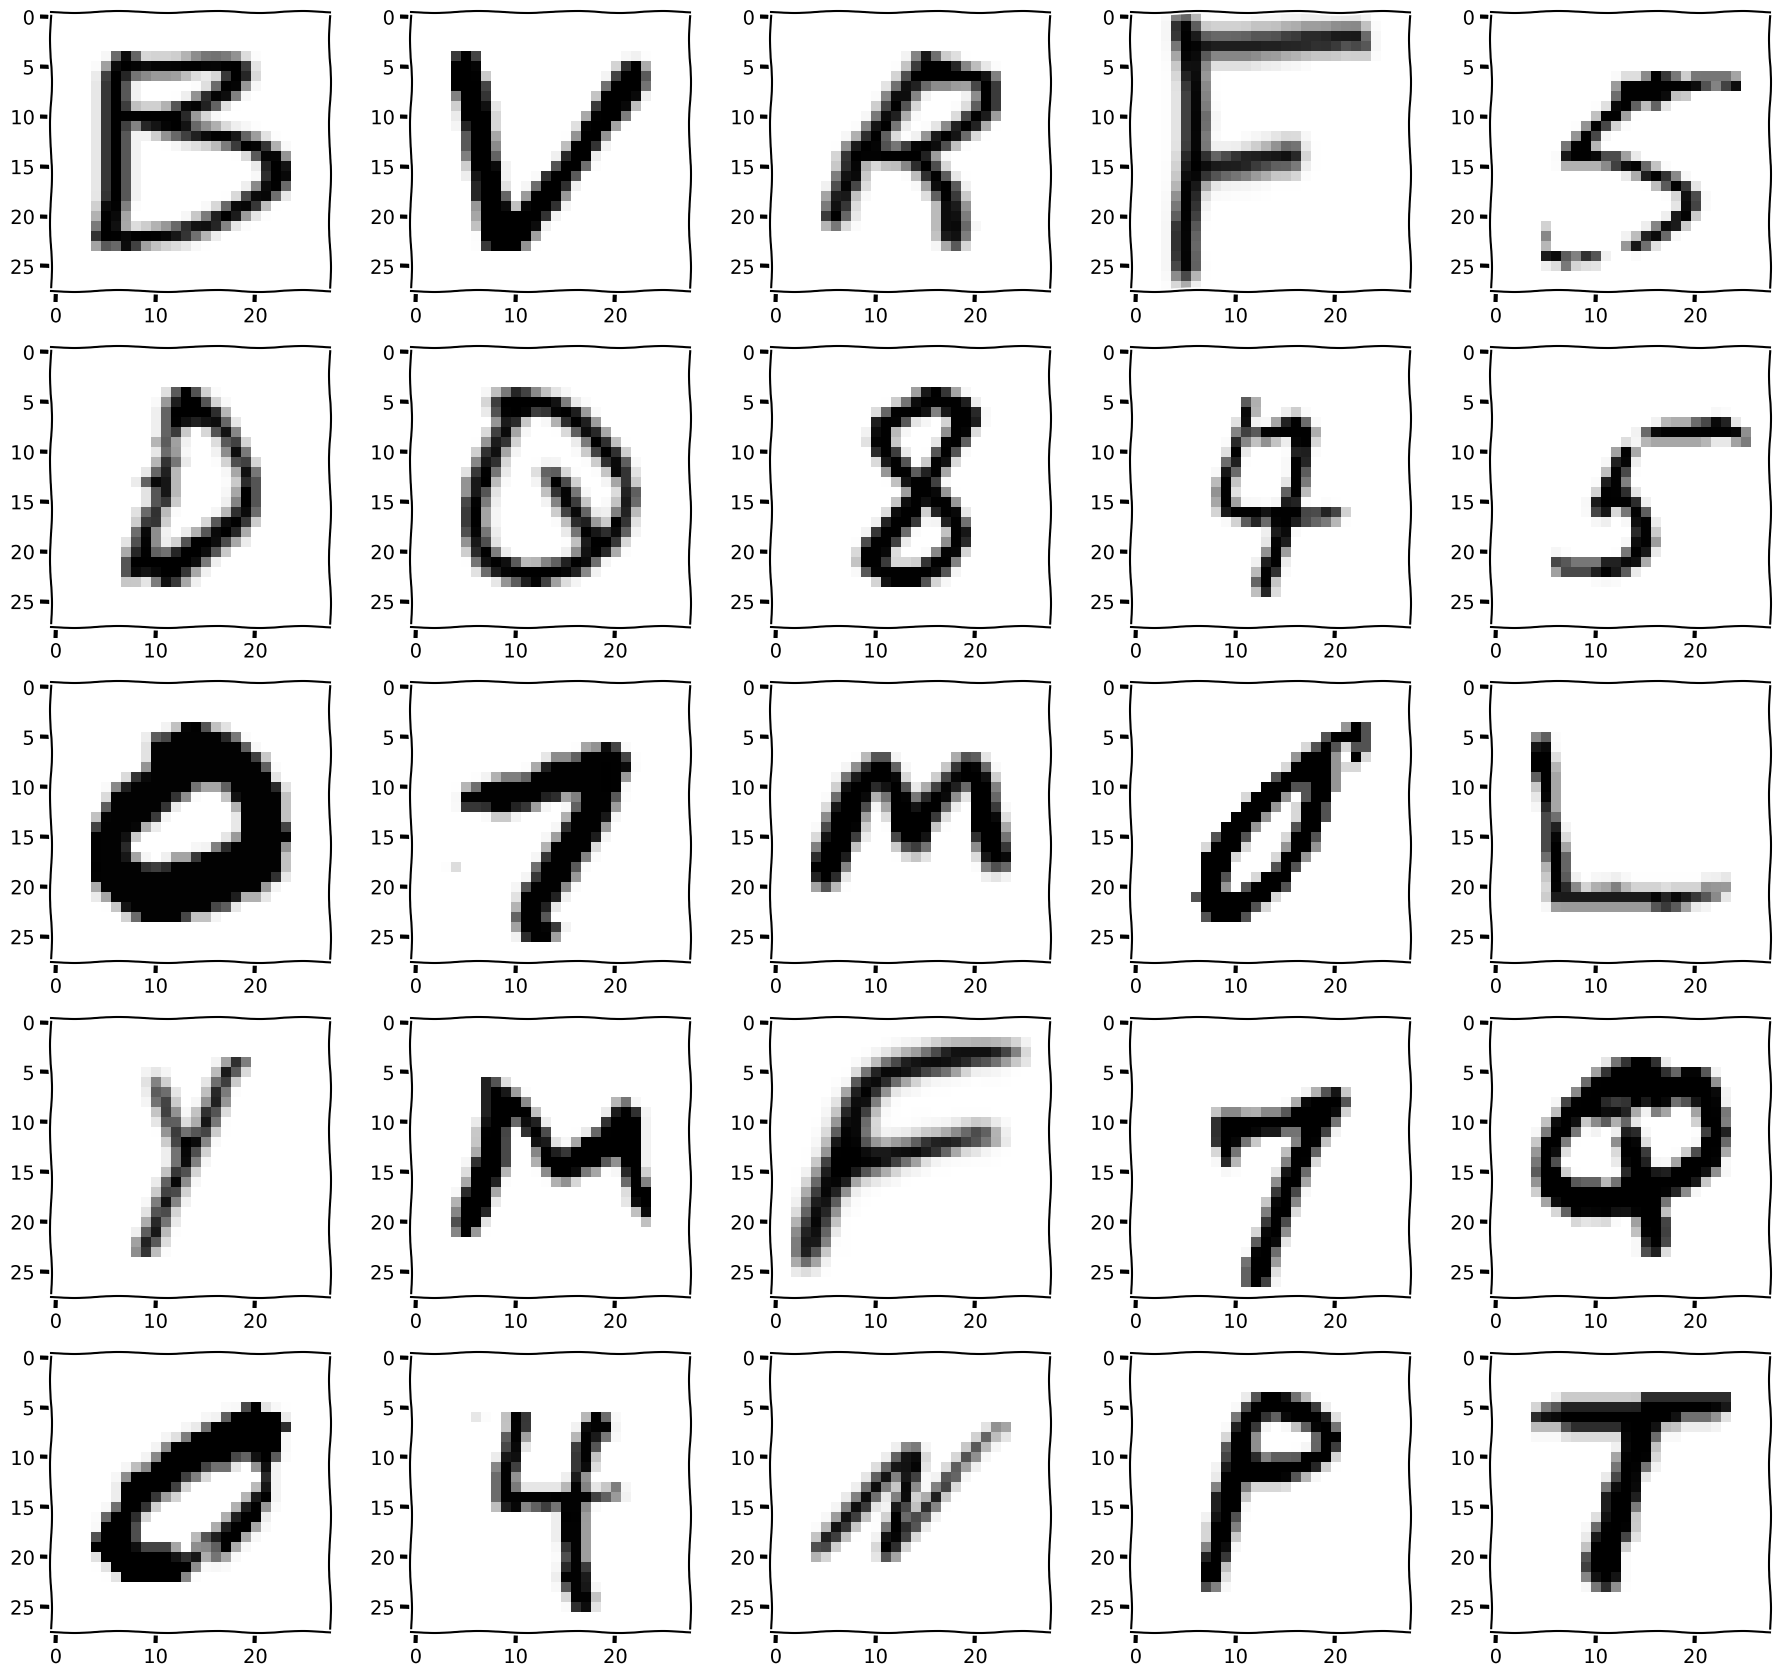

In [35]:
# Now we shuffle the data with the shuffle() function to show the random images..

# plt.style.use('fivethirtyeight')
plt.xkcd()

shuff = shuffle(x_train[:100])
fig, ax = plt.subplots(5, 5, figsize = (20, 20))
axes = ax.flatten()

for i in range(25):
    shu = cv2.threshold(shuff[i], 30, 200, cv2.THRESH_BINARY)
    axes[i].imshow(np.reshape(shuff[i], (28, 28)), cmap = 'Greys')
plt.show()

# Changing the shape of images in the training and testing datasets to fit into the Deep Learning Model.

In [36]:
# Reshaping the training & test dataset so that it can be put in the model
# Now we reshape the train & test image dataset so that they can be put in the model.
# New shape of train data: (297960, 28, 28, 1)
# New shape of test data: (74490, 28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
print("New shape of train data:", x_train.shape)

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print("New shape of test data:", x_test.shape)

New shape of train data: (115200, 28, 28, 1)
New shape of test data: (28800, 28, 28, 1)


# Change decimal numbers to categories

In [37]:
# Here we convert the single float values to categorical values. 
# This is done as the CNN model takes input of labels & generates the output as a vector of probabilities.

# What is CNN?
#   CNN stands for Convolutional Neural Networks 
#   that are used to extract the features of the images using several layers of filters.

categorical_train = to_categorical(y_train, num_classes = 36, dtype = 'int')
print("New shape of train labels:", categorical_train.shape)

categorical_test = to_categorical(y_test, num_classes = 36, dtype = 'int')
print("New shape of test labels:", categorical_test.shape)

New shape of train labels: (115200, 36)
New shape of test labels: (28800, 36)


# Augmentation layer

In [44]:
data_augmentation = Sequential([
    RandomRotation(0.05),
    RandomZoom((-0.1, 0.2)),])

# Implementation of Deep Learning Model

In [51]:
# We have the Sequential model that we designed for training the model over the training dataset.
# The model created is as follows:

# Sequential() Model: A Sequential model is appropriate for a plain stack of layers 
# where each layer has exactly one input tensor and one output tensor.

# MaxPool2D: The input along its spatial dimensions (height and width) by taking the maximum value over an input window
#(of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

my_model = Sequential()

# layer augmentation
my_model.add(data_augmentation)

my_model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
my_model.add(MaxPool2D(pool_size = (2, 2), strides = 2))

my_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
my_model.add(MaxPool2D(pool_size = (2, 2), strides = 2))

my_model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'valid'))
my_model.add(MaxPool2D(pool_size = (2, 2), strides = 2))

my_model.add(Flatten())

my_model.add(Dense(64, activation = "relu"))
my_model.add(Dense(128, activation = "relu"))

my_model.add(Dense(36, activation = "linear"))

# Compiling the Model

In [52]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [53]:
my_model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])


In [54]:
print("X_train: ",x_train.shape)
print("categorical_train: ", categorical_train.shape)

X_train:  (115200, 28, 28, 1)
categorical_train:  (115200, 36)


In [55]:
print("X_test: ",x_test.shape)
print("categorical_test: ", categorical_test.shape)

X_test:  (28800, 28, 28, 1)
categorical_test:  (28800, 36)


In [56]:
history = my_model.fit(x_train, categorical_train,
                       epochs = 100,
                       batch_size=256,
                       validation_data = (x_test, categorical_test))

Epoch 1/100
450/450 [==============================] - 6s 7ms/step - loss: 1.1256 - accuracy: 0.7088 - val_loss: 0.2859 - val_accuracy: 0.9127
Epoch 2/100
450/450 [==============================] - 3s 6ms/step - loss: 0.2862 - accuracy: 0.9076 - val_loss: 0.2080 - val_accuracy: 0.9364
Epoch 3/100
450/450 [==============================] - 3s 6ms/step - loss: 0.2228 - accuracy: 0.9282 - val_loss: 0.1835 - val_accuracy: 0.9463
Epoch 4/100
450/450 [==============================] - 3s 6ms/step - loss: 0.1856 - accuracy: 0.9398 - val_loss: 0.1706 - val_accuracy: 0.9455
Epoch 5/100
450/450 [==============================] - 3s 6ms/step - loss: 0.1708 - accuracy: 0.9439 - val_loss: 0.1768 - val_accuracy: 0.9441
Epoch 6/100
450/450 [==============================] - 3s 6ms/step - loss: 0.1561 - accuracy: 0.9485 - val_loss: 0.1423 - val_accuracy: 0.9580
Epoch 7/100
450/450 [==============================] - 3s 6ms/step - loss: 0.1459 - accuracy: 0.9519 - val_loss: 0.1371 - val_accuracy: 0.9582

# Getting summary of Model

In [57]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)        

# Locate the accuracy and losses of the model

In [58]:
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation accuracy is : [0.9127083420753479, 0.9363541603088379, 0.9462847113609314, 0.9454513788223267, 0.9440624713897705, 0.958020806312561, 0.9581944346427917, 0.9631944298744202, 0.96114581823349, 0.9644444584846497, 0.9677083492279053, 0.9633680582046509, 0.9586111307144165, 0.9659028053283691, 0.9667708277702332, 0.9657986164093018, 0.9665277600288391, 0.9666666388511658, 0.9653124809265137, 0.9670485854148865, 0.9676735997200012, 0.957604169845581, 0.9648264050483704, 0.968993067741394, 0.9677083492279053, 0.9681597352027893, 0.9679166674613953, 0.9636458158493042, 0.9648264050483704, 0.9683333039283752, 0.9680208563804626, 0.968715250492096, 0.9670485854148865, 0.9701041579246521, 0.9697916507720947, 0.9682638645172119, 0.9673264026641846, 0.9664236307144165, 0.9674305319786072, 0.9672569632530212, 0.9659028053283691, 0.9682291746139526, 0.9703472256660461, 0.9686805605888367, 0.9711458086967468, 0.9710069298744202, 0.9697569608688354, 0.9676735997200012, 0.96944445371627

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


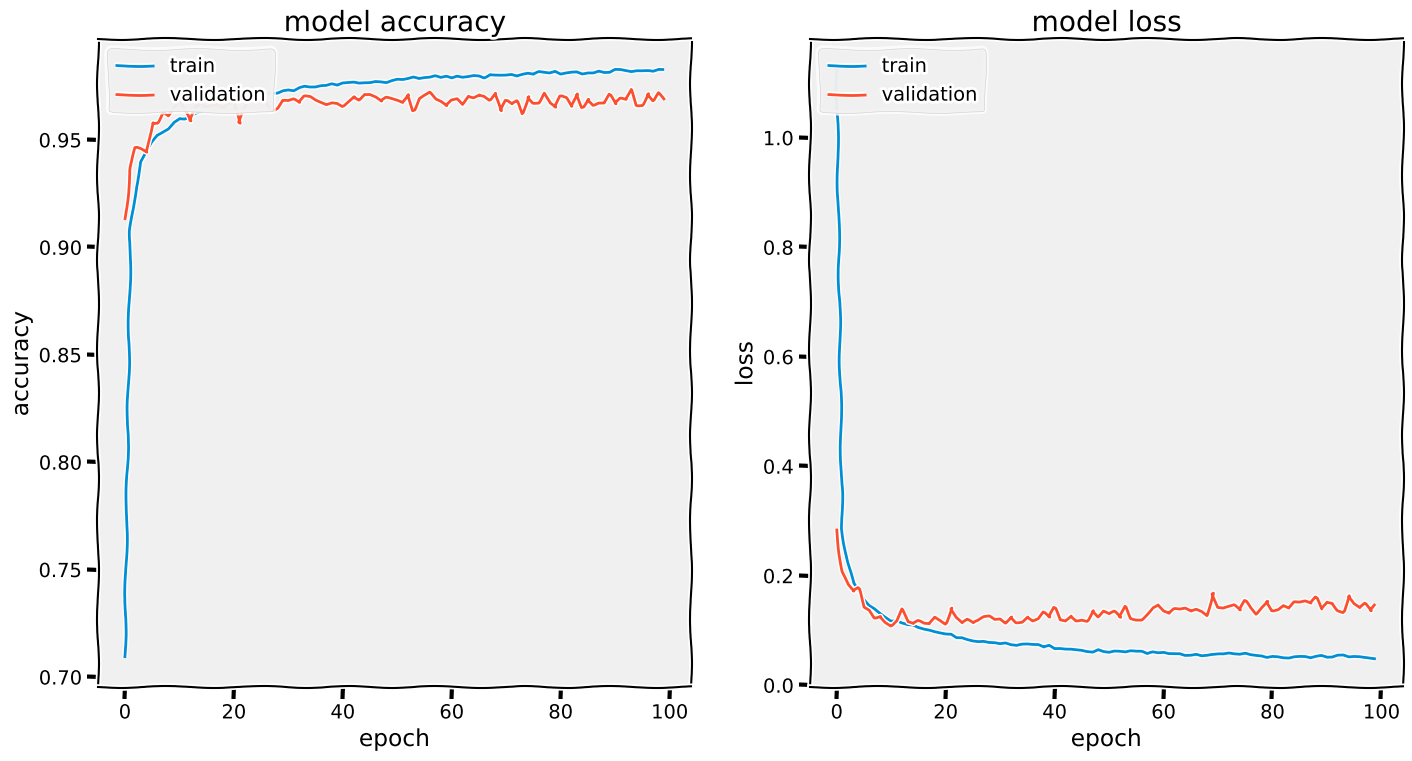

In [59]:
print(history.history.keys())
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# "Loss"
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# make predictions on the test data

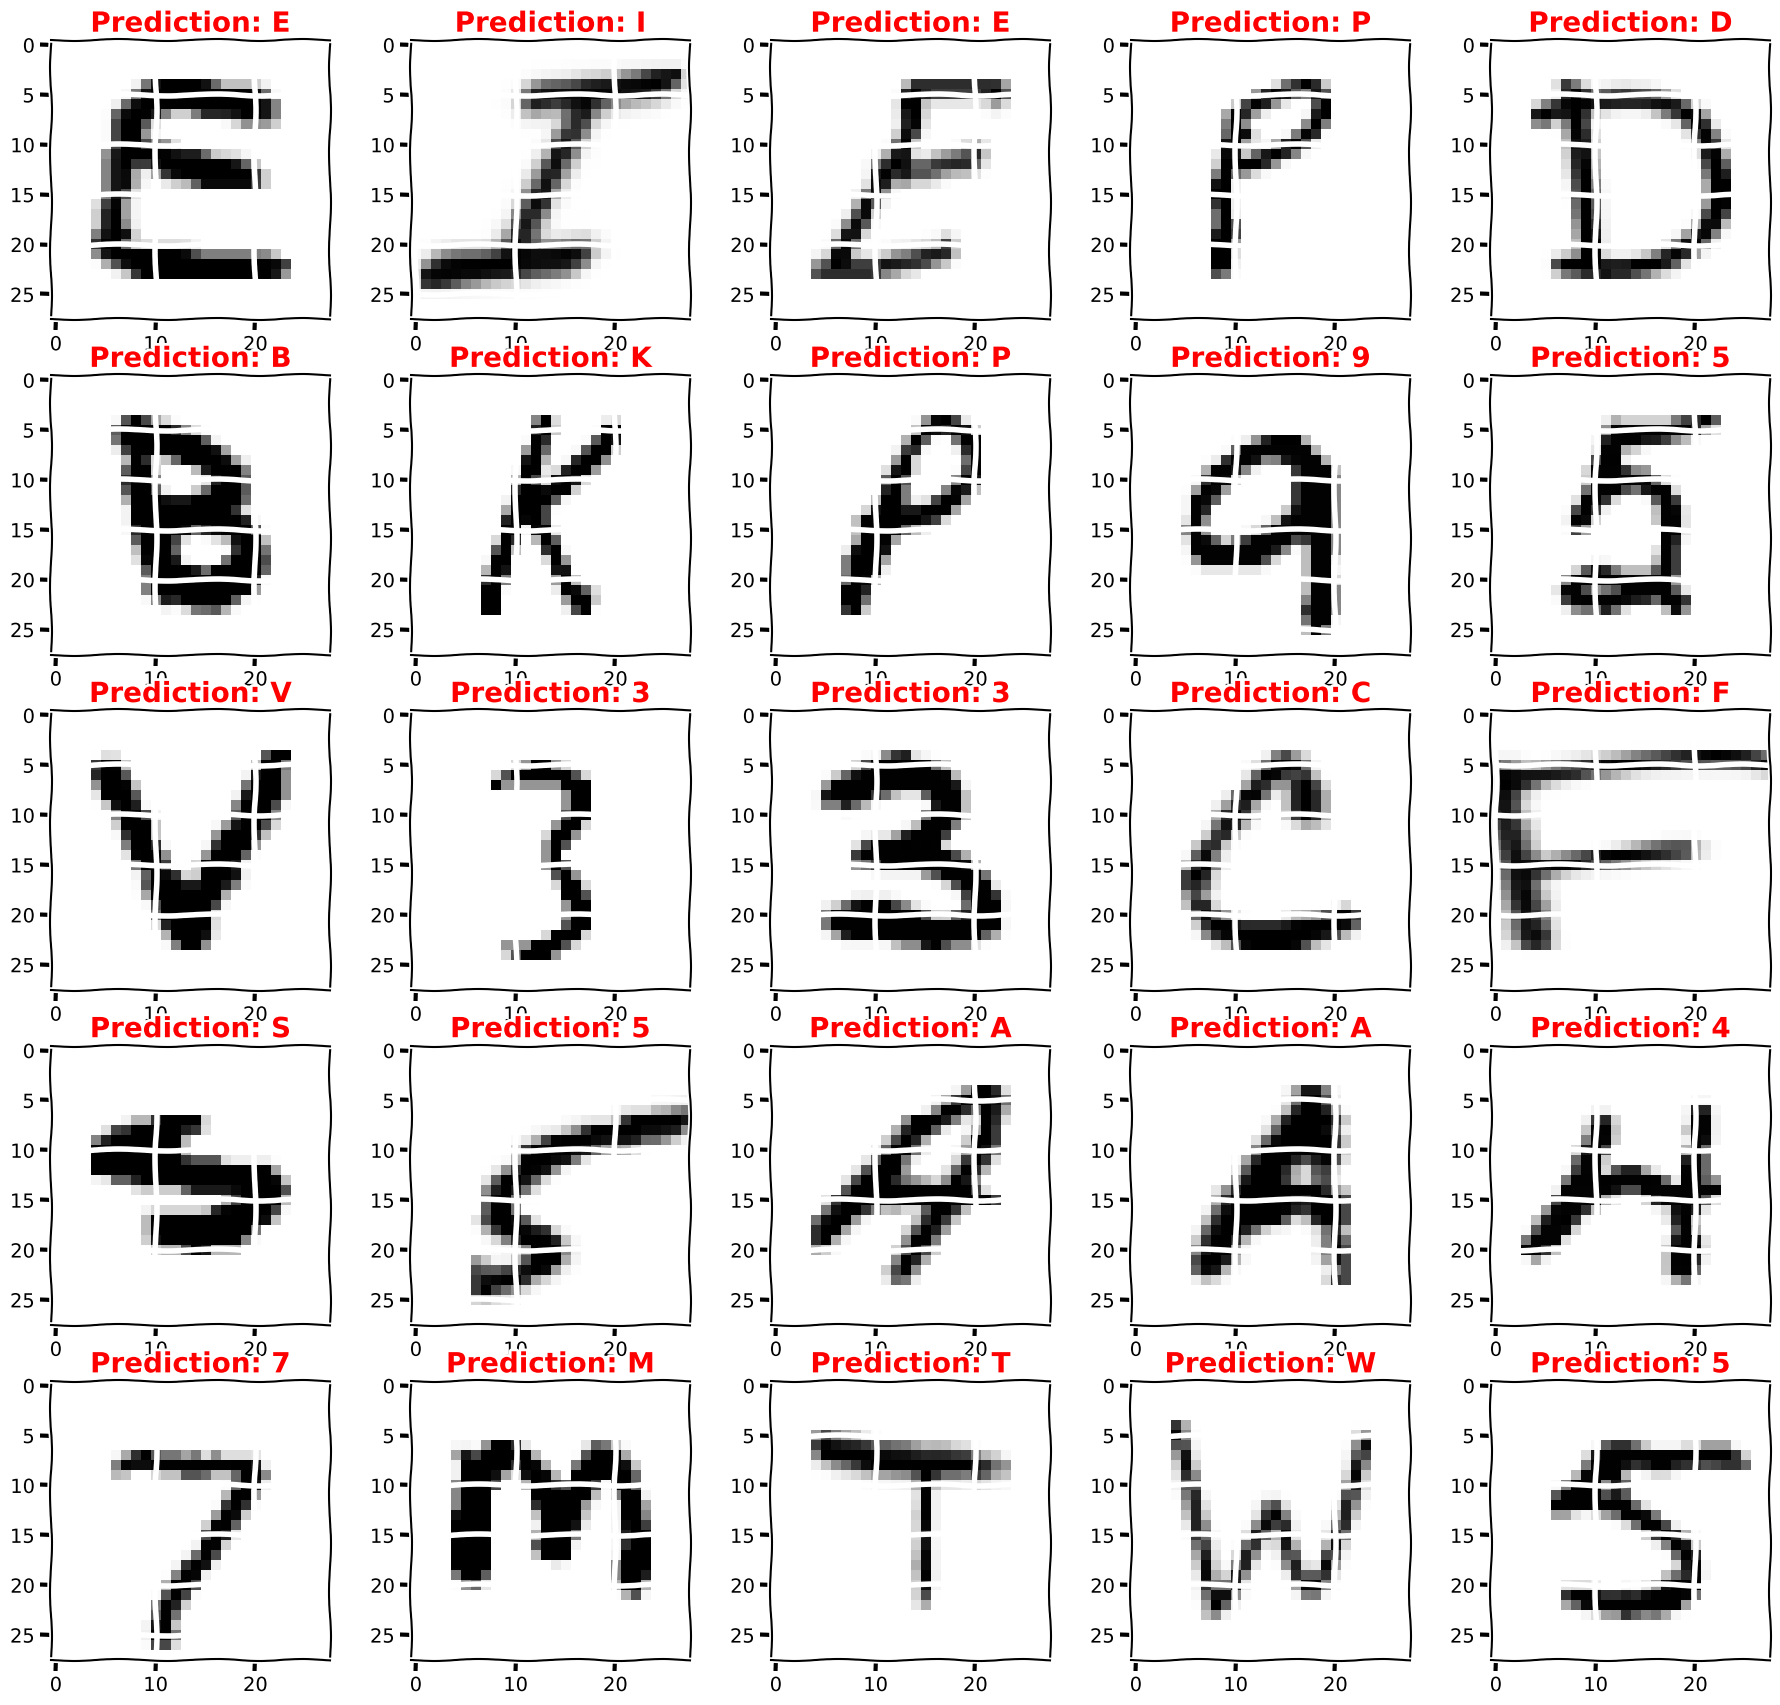

In [60]:
plt.style.use('fivethirtyeight')
plt.xkcd()

fig, axes = plt.subplots(5, 5, figsize = (20, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = np.reshape(x_test[i], (28, 28))
    ax.imshow(img, cmap = 'Greys')
    
    pred = word_dict[np.argmax(categorical_test[i])]
    ax.set_title("Prediction: " + pred, fontsize = 20, fontweight = 'bold', color = 'red')
    ax.grid()

In [61]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [62]:

def print_confusion_matrix(y_true, y_pred, report=True):
#     print(y_true[:5])
#     print(y_pred[:5])
    plt.figure(figsize=(25,25))
    labels = sorted(word_dict.keys())
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = my_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = y_test
# y_pred = [word_dict[val] for val in y_pred]
# y_true = [word_dict[val] for val in y_true]
print_confusion_matrix(y_true, y_pred)

900/900 [==============================] - 2s 2ms/step
Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       849
         1.0       0.98      0.96      0.97       794
         2.0       0.99      0.97      0.98       794
         3.0       0.96      0.97      0.97       754
         4.0       0.97      0.99      0.98       812
         5.0       0.99      0.99      0.99       786
         6.0       0.98      0.98      0.98       832
         7.0       0.97      0.98      0.97       813
         8.0       0.99      0.99      0.99       791
         9.0       0.97      0.98      0.98       764
        10.0       0.99      0.96      0.97       828
        11.0       0.98      0.99      0.98       778
        12.0       0.99      0.98      0.99       779
        13.0       0.97      0.98      0.97       790
        14.0       0.90      0.77      0.83       801
        15.0       0.99      0.98      0.98       827
    

<Figure size 2500x2500 with 0 Axes>

# Save model

In [63]:
my_model.save('/kaggle/working/handwritten_classifier_v2.hdf5', include_optimizer=False)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
my_model.save('/kaggle/working/handwritten_classifier_v2.keras')

In [65]:
import tensorflow as tf

In [66]:
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open('/kaggle/working/handwritten_classifier_v2.tflite', 'wb').write(tflite_quantized_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 8, Total Ops 26, % non-converted = 30.77 %
 * 8 ARITH ops

- arith.constant:    8 occurrences  (f32: 7, i32: 1)



  (f32: 3)
  (f32: 3)
  (f32: 3)
  (uq_8: 5)
  (f32: 1)


147592

In [67]:
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/handwritten_classifier_v2.tflite')
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [68]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [69]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 46 µs, sys: 802 µs, total: 848 µs
Wall time: 1.9 ms


In [70]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf]
0
